In [100]:
import pandas as pd
import numpy as np
import catboost
from catboost import CatBoostRanker,Pool

In [101]:
train=pd.read_parquet('../Data/small_train_feature_engineered_2.parquet',engine='pyarrow')
val=pd.read_parquet('../Data/small_val_feature_engineered_2.parquet',engine='pyarrow')

In [102]:
train

,id2,id3,id4,id5,y,f1,f2,f5,f6,f7,...,num_offer_categories,sub_category,num_sub_categories,previous_offer_category,previous_suboffer_category,no_of_clicks_previously,pace_x_ctr,session_count_x_ctr,pace_x_offer_popularity,time_since_last_click
0,1000624,5243695,2023-11-01 03:31:21.598,2023-11-01,0,56.0,NaN,33.0,16.0,33.0,...,1,Other,1,missing,missing,0,NaN,0.000000,NaN,NaN
1,1000624,97646,2023-11-01 03:31:21.618,2023-11-01,0,56.0,NaN,33.0,16.0,33.0,...,1,Apparel,1,Shopping,Other,0,0.000000,0.000000,0.001123,NaN
2,1000639,81010,2023-11-01 13:00:17.848,2023-11-01,0,44.0,NaN,24.0,46.0,42.0,...,1,Other,1,missing,missing,0,NaN,0.005056,NaN,NaN
3,1000639,830157,2023-11-01 13:00:20.013,2023-11-01,0,44.0,NaN,24.0,46.0,42.0,...,1,Gifts,1,Shopping,Other,0,0.010947,0.010112,0.130172,NaN
4,1000639,24840,2023-11-01 13:00:22.564,2023-11-01,0,44.0,NaN,24.0,46.0,42.0,...,1,Clothing_Gifts_Jewelry,3,Shopping,Gifts,0,0.018441,0.021687,0.285766,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124373,1910541,80107221,2023-11-01 05:46:56.017,2023-11-01,0,NaN,NaN,63.0,65.0,NaN,...,1,Other,1,Services,None,0,0.000000,0.000000,NaN,NaN
124374,1910541,224505,2023-11-01 07:43:02.618,2023-11-01,0,NaN,NaN,63.0,65.0,NaN,...,1,Other,1,Shopping,Other,0,0.000000,0.000000,480.712545,NaN
124375,1910541,5420674,2023-11-01 07:43:31.173,2023-11-01,0,NaN,NaN,63.0,65.0,NaN,...,1,Other,1,Shopping,Other,0,0.000000,0.000000,NaN,NaN
124376,1910541,82192,2023-11-01 07:43:31.452,2023-11-01,0,NaN,NaN,63.0,65.0,NaN,...,1,Clothing,1,Shopping,Other,0,0.000000,0.000000,0.021704,NaN


In [103]:
# --- YOUR HACKATHON METRIC FUNCTION ---
def map_at_k_hackathon(y_true, y_pred_scores, group_ids, k=7):
    """
    Calculates the Mean Average Precision at k.
    """
    df = pd.DataFrame({'group': group_ids, 'y_true': y_true, 'score': y_pred_scores})
    
    average_precisions = []
    total_relevant_per_group = df[df['y_true'] == 1].groupby('group')['y_true'].count()

    for group_id, group_df in df.groupby('group'):
        total_relevant = total_relevant_per_group.get(group_id, 0)
        if total_relevant == 0:
            continue

        group_df = group_df.sort_values('score', ascending=False).head(k)
        
        hits = 0
        precision_sum = 0.0
        
        for i, row in enumerate(group_df.itertuples(index=False)):
            rank = i + 1
            if row.y_true == 1:
                hits += 1
                precision_at_k = hits / rank
                precision_sum += precision_at_k
        
        ap = precision_sum / total_relevant
        average_precisions.append(ap)

    return np.mean(average_precisions) if average_precisions else 0.0


In [104]:
cat_features_names = train.select_dtypes(include=['category']).columns.tolist()


In [105]:
cat_features_names.remove('id2')
cat_features_names.remove('id3')

In [106]:
for df in [train, val]:
    for col in cat_features_names:
        if df[col].dtype.name == 'category':
            df[col] = df[col].cat.add_categories('NotAvailable')
    df[cat_features_names] = df[cat_features_names].fillna('NotAvailable')
print("Successfully handled null values.")

Successfully handled null values.


In [107]:
# --- 1. Preprocessing & Data Preparation ---
# (Assuming preprocessing like handling nulls is already done)
TARGET = 'y'
FEATURES = [col for col in train.columns if col not in [TARGET, 'id2', 'id3','id4','id5']]

In [108]:
train.dtypes

id2                              category
id3                              category
id4                        datetime64[ns]
id5                        datetime64[ns]
y                                    int8
                                ...      
no_of_clicks_previously             int64
pace_x_ctr                        float64
session_count_x_ctr               float64
pace_x_offer_popularity           float64
time_since_last_click             float64
Length: 227, dtype: object

In [109]:
train

,id2,id3,id4,id5,y,f1,f2,f5,f6,f7,...,num_offer_categories,sub_category,num_sub_categories,previous_offer_category,previous_suboffer_category,no_of_clicks_previously,pace_x_ctr,session_count_x_ctr,pace_x_offer_popularity,time_since_last_click
0,1000624,5243695,2023-11-01 03:31:21.598,2023-11-01,0,56.0,NaN,33.0,16.0,33.0,...,1,Other,1,missing,missing,0,NaN,0.000000,NaN,NaN
1,1000624,97646,2023-11-01 03:31:21.618,2023-11-01,0,56.0,NaN,33.0,16.0,33.0,...,1,Apparel,1,Shopping,Other,0,0.000000,0.000000,0.001123,NaN
2,1000639,81010,2023-11-01 13:00:17.848,2023-11-01,0,44.0,NaN,24.0,46.0,42.0,...,1,Other,1,missing,missing,0,NaN,0.005056,NaN,NaN
3,1000639,830157,2023-11-01 13:00:20.013,2023-11-01,0,44.0,NaN,24.0,46.0,42.0,...,1,Gifts,1,Shopping,Other,0,0.010947,0.010112,0.130172,NaN
4,1000639,24840,2023-11-01 13:00:22.564,2023-11-01,0,44.0,NaN,24.0,46.0,42.0,...,1,Clothing_Gifts_Jewelry,3,Shopping,Gifts,0,0.018441,0.021687,0.285766,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124373,1910541,80107221,2023-11-01 05:46:56.017,2023-11-01,0,NaN,NaN,63.0,65.0,NaN,...,1,Other,1,Services,None,0,0.000000,0.000000,NaN,NaN
124374,1910541,224505,2023-11-01 07:43:02.618,2023-11-01,0,NaN,NaN,63.0,65.0,NaN,...,1,Other,1,Shopping,Other,0,0.000000,0.000000,480.712545,NaN
124375,1910541,5420674,2023-11-01 07:43:31.173,2023-11-01,0,NaN,NaN,63.0,65.0,NaN,...,1,Other,1,Shopping,Other,0,0.000000,0.000000,NaN,NaN
124376,1910541,82192,2023-11-01 07:43:31.452,2023-11-01,0,NaN,NaN,63.0,65.0,NaN,...,1,Clothing,1,Shopping,Other,0,0.000000,0.000000,0.021704,NaN


In [110]:

# CRITICAL: Sort data by the user ID
train = train.sort_values(['id2','id4']).reset_index(drop=True)
val = val.sort_values(['id2','id4']).reset_index(drop=True)


In [111]:

# Define your data sets
X_train = train[FEATURES]

In [112]:

y_train = train[TARGET].astype(int)


In [113]:
X_val = val[FEATURES]


In [114]:

y_val = val[TARGET].astype(int)


In [115]:

# Identify categorical features
cat_features_names = X_train.select_dtypes(include=['category', 'object']).columns.tolist()
cat_features_indices = [X_train.columns.get_loc(col) for col in cat_features_names]


In [116]:


# --- 2. Create catboost.Pool Objects ---
# Bundle the training data into a Pool
train_pool = Pool(
    data=X_train,
    label=y_train,
    group_id=train['id2'],
    cat_features=cat_features_indices
)


In [117]:

# Bundle the validation data into a Pool
validation_pool = Pool(
    data=X_val,
    label=y_val,
    group_id=val['id2'],
    cat_features=cat_features_indices
)


In [118]:


# --- 3. Model Training ---
model = CatBoostRanker(
    iterations=1500,
    learning_rate=0.05,
    random_seed=42,
    verbose=100,
    loss_function='LambdaMart',
    eval_metric='MAP:top=7'
)


In [119]:

print("\nStarting CatBoostRanker training...")

# Pass the Pool objects to the .fit() method
model.fit(
    train_pool,
    eval_set=validation_pool,
    early_stopping_rounds=100,
    use_best_model=True
)



Starting CatBoostRanker training...
Groupwise loss function. OneHotMaxSize set to 10
0:	learn: 0.0953058	test: 0.0681083	best: 0.0681083 (0)	total: 105ms	remaining: 2m 38s
100:	learn: 0.1361163	test: 0.0930495	best: 0.0930495 (100)	total: 8.12s	remaining: 1m 52s
200:	learn: 0.1442709	test: 0.0966911	best: 0.0966911 (200)	total: 17s	remaining: 1m 50s
300:	learn: 0.1506614	test: 0.0987800	best: 0.0987800 (300)	total: 24.1s	remaining: 1m 36s
400:	learn: 0.1557011	test: 0.0996354	best: 0.0997474 (392)	total: 31s	remaining: 1m 24s
500:	learn: 0.1596595	test: 0.1004540	best: 0.1004540 (500)	total: 37.8s	remaining: 1m 15s
600:	learn: 0.1640124	test: 0.1005005	best: 0.1007342 (575)	total: 44.6s	remaining: 1m 6s
700:	learn: 0.1670707	test: 0.1016028	best: 0.1016028 (700)	total: 51.4s	remaining: 58.6s
800:	learn: 0.1699207	test: 0.1015666	best: 0.1019129 (758)	total: 59s	remaining: 51.5s
900:	learn: 0.1729071	test: 0.1017352	best: 0.1020008 (852)	total: 1m 6s	remaining: 44.4s
1000:	learn: 0.175

In [120]:

# --- 4. Prediction ---
# Prediction still works on the DataFrame directly
val_scores = model.predict(X_val)

print("\nTraining complete!")
print(f"Best validation MAP@7: {model.get_best_score()['validation']['MAP:top=7']:.4f}")


Training complete!
Best validation MAP@7: 0.1020


In [121]:
map7 = map_at_k_hackathon(y_val.values, val_scores, val['id2'].values, k=7)
print(f"Hackathon MAP@7: {map7:.4f}")

/var/folders/7w/qs77cz_11630n9gydm61vjpc0000gn/T/ipykernel_90806/3676040123.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_relevant_per_group = df[df['y_true'] == 1].groupby('group')['y_true'].count()
/var/folders/7w/qs77cz_11630n9gydm61vjpc0000gn/T/ipykernel_90806/3676040123.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group_id, group_df in df.groupby('group'):


Hackathon MAP@7: 0.6867


In [122]:
X_train_sample=X_train.sample(1000, random_state=42)

Initializing SHAP TreeExplainer...
Calculating SHAP values for the sample data...

--- Global Feature Importance (Summary Plot) ---


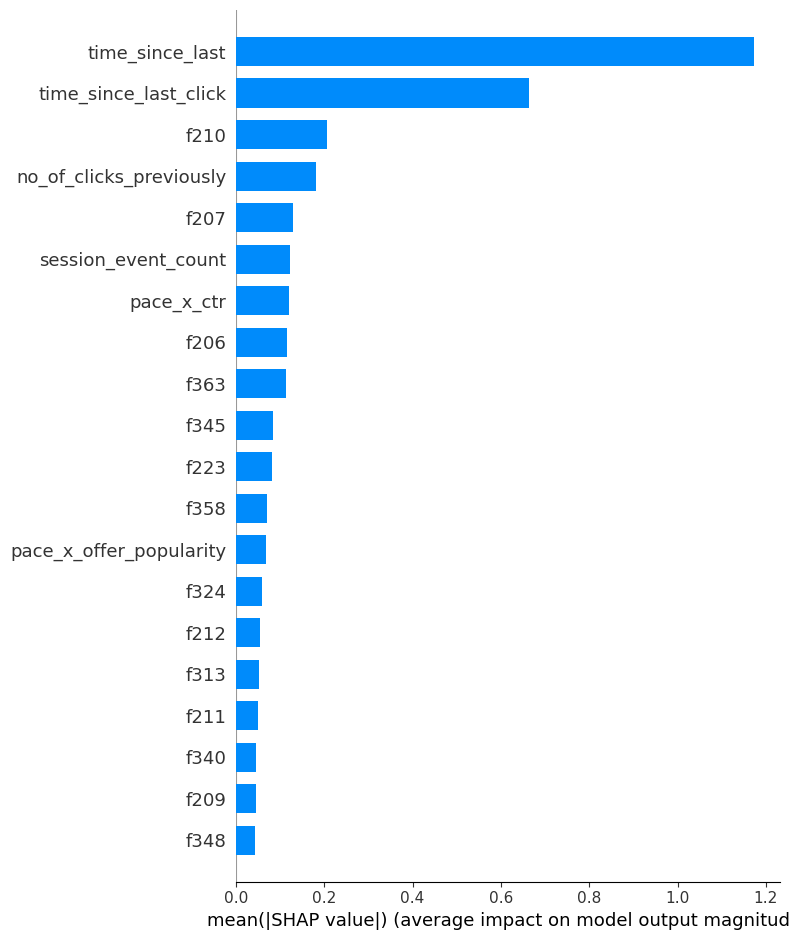


--- Waterfall Plot for a Single Prediction ---


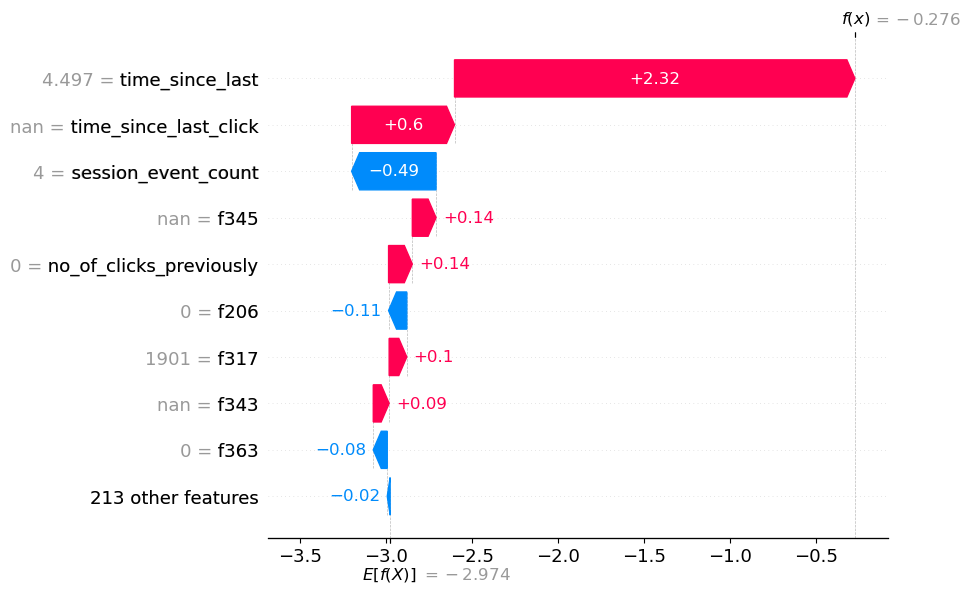

In [123]:
# plot shap waterfall plot
import shap
import matplotlib.pyplot as plt

# --- 1. Initialize Explainer and Calculate SHAP Values ---
print("Initializing SHAP TreeExplainer...")
# Create the explainer object with your trained CatBoostRanker model
explainer = shap.TreeExplainer(model)

print("Calculating SHAP values for the sample data...")
# Calculate the SHAP values. This can take a moment.
shap_values = explainer.shap_values(X_train_sample)


# --- 2. Print Aggregated SHAP Values (Global Feature Importance) ---
# The summary plot is the best way to visualize the overall importance.
print("\n--- Global Feature Importance (Summary Plot) ---")
shap.summary_plot(shap_values, X_train_sample, plot_type="bar")


# --- 3. Create a Waterfall Plot for a Single Prediction ---
# A waterfall plot explains how each feature contributes to one specific prediction.
# Let's explain the prediction for the first row in our sample.
print("\n--- Waterfall Plot for a Single Prediction ---")

# The explainer object has an expected_value (the baseline score for all predictions)
# We use the SHAP values and feature values for the first instance (index 0)
shap.waterfall_plot(shap.Explanation(
    values=shap_values[0],
    base_values=explainer.expected_value,
    data=X_train_sample.iloc[0],
    feature_names=X_train_sample.columns.tolist()
))

In [124]:
import pandas as pd
import numpy as np

# Assume 'shap_values' and 'X_val_sample' are already calculated from the previous step

# 1. Calculate the mean absolute SHAP value for each feature
# This summarizes the impact of each feature across all the samples
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# 2. Create a pandas DataFrame for easy viewing
shap_df = pd.DataFrame({
    'feature_name': X_train_sample.columns,
    'mean_abs_shap_value': mean_abs_shap
})

# 3. Sort the DataFrame to see the most impactful features at the top
shap_df = shap_df.sort_values('mean_abs_shap_value', ascending=False).reset_index(drop=True)

# 4. Display the resulting table
print("--- Top 25 Most Important Features (based on Mean SHAP Value) ---")
shap_df

--- Top 25 Most Important Features (based on Mean SHAP Value) ---


,feature_name,mean_abs_shap_value
0,time_since_last,1.173217
1,time_since_last_click,0.664284
2,f210,0.205855
3,no_of_clicks_previously,0.180473
4,f207,0.130420
...,...,...
217,f160,0.000224
218,f75,0.000020
219,f50,0.000000
220,f52,0.000000
